In [340]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import scipy
import math
import bitarray
import random
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,4)

In [341]:
#message to transmit
ba = bitarray.bitarray()
file = open('message.txt', 'rb')
ba.fromfile(file)
data = np.array(ba.tolist()).astype(int)
text_size = len(data)
print(text_size)

1608


# Encoder

In [342]:
Fs = 22050 #sampling freq. in hz
Fc = 441 #frequency of carrier signal
baud_rate = Fc #need to be less than Fc
modulation_freq_1 = 3000 #modulation frequency in hertz of first sine
modulation_freq_2 = 7000 #modulation frequency in hertz of second sine
T = (data_size/baud_rate) #length in sec
sample_per_bit = int(Fs/baud_rate)
start_sequence = [+1, +1, +1, +1, +1, 0, 0, +1, +1, 0, +1, 0, +1]
print(T)
print(sample_per_bit)

0.2653061224489796
50


In [343]:
#append start/stop sequence to message :
data = np.concatenate((start_sequence,data))
data_size = len(data)
#transform 0 to -1 in data 
data_tx = np.ones(len(data))
data_tx[data==0] = -1

In [344]:
#upsample data :
data_tx = np.repeat(data_tx,sample_per_bit)
#modulate carrier with data :
tx_signal = np.sqrt(2) * np.sin(np.arange(0, len(data_tx)) * 2 *np.pi * (Fc/Fs)) * data_tx 

<StemContainer object of 3 artists>

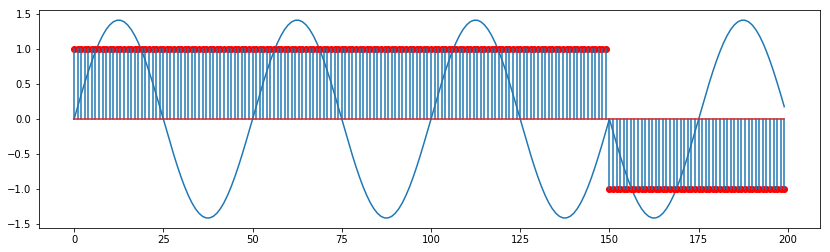

In [345]:
#plot first samples of tx_signal
plt.plot(tx_signal[100:300])
plt.stem(data_tx[100:300],markerfmt = 'ro')

In [346]:
tx_fft = np.abs(np.fft.fft(tx_signal))
N = int(len(tx_fft)/2)
#plt.plot(np.linspace(0,1,N) * (Fs/2), tx_fft[0:N]);

In [347]:
#modulate signal on 2 orthogonals carriers
carrier_1 = tx_signal * np.cos(np.arange(0,len(tx_signal)) * 2 * np.pi * (modulation_freq_1/Fs))
carrier_2 = tx_signal * np.cos(np.arange(0,len(tx_signal)) * 2 * np.pi * (modulation_freq_2/Fs))
tx_signal_modulated = carrier_1 + carrier_2

In [348]:
tx_modulated_fft = np.abs(np.fft.fft(tx_signal_modulated))
N = int(len(tx_fft)/2)
#plt.plot(np.linspace(0,1,N) * (Fs/2), tx_modulated_fft[0:N]);

In [349]:
rx_file = tx_signal_modulated.tofile("tx.txt",sep='\n',format='%f')

In [350]:
!python client.py --input_file=tx.txt --output_file=rx.txt --srv_hostname=iscsrv72.epfl.ch --srv_port=80

# Channel

In [351]:
# channel
#frequency cut
erase_indice = random.randint(1,4) #band to erase 
channel_signal = tx_signal_modulated
channel_signal_fft = scipy.fftpack.fft(channel_signal)
N = len(channel_signal_fft)
erase_low_freq = (erase_indice * 2000 - 1000) * N  / (Fs)
erase_high_freq = erase_low_freq + (2000 * N / (Fs))
channel_signal_fft[int(erase_low_freq):int(erase_high_freq)] = 0
channel_signal = scipy.fftpack.ifft(channel_signal_fft)

#noise
noise_length = 1100
noise = noise = np.random.normal(0,0.05,len(tx_signal_modulated)+noise_length)
#rx_signal = np.concatenate((np.zeros(noise_length),channel_signal)) + noise
#rx_signal = channel_signal + noise

In [352]:
#plt.plot(rx_signal)

In [353]:
#N = int(len(rx_signal)/2)
#rx_fft = np.abs(np.fft.fft(rx_signal))
#plt.plot(np.linspace(0,1,N) * (Fs/2), rx_fft[0:N]);

# Decoder

In [354]:
start_sequence_bis = [+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1]
training_upsampled = np.repeat(start_sequence_bis,sample_per_bit)
training_signal = np.sqrt(2) * np.sin(np.arange(0, len(training_upsampled)) * 2 *np.pi * sample_per_bit) * training_upsampled 

In [355]:
rx_signal = np.fromfile("rx.txt",sep='\n',dtype='float')

In [356]:
#lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sp.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.filtfilt(b, a, data)
    return y

In [357]:
# demodulate both carriers
rx_demod_carrier_1 = rx_signal * np.cos(2 * np.pi * (modulation_freq_1/Fs) * np.arange(0,len(rx_signal)))
rx_demod_carrier_2 = rx_signal * np.cos(2 * np.pi * (modulation_freq_2/Fs) * np.arange(0,len(rx_signal)))
#fft
#rx_demod_carrier_1_fft = np.abs(np.fft.fft(rx_demod_carrier_1))
#rx_demod_carrier_2_fft = np.abs(np.fft.fft(rx_demod_carrier_2))
#N = int(len(rx_demod_carrier_1_fft))
#plt.plot(np.linspace(0,1,N) * (Fs/2), rx_demod_carrier_1_fft[0:N]);
#plt.figure()
#plt.plot(np.linspace(0,1,N) * (Fs/2), rx_demod_carrier_2_fft[0:N]);

In [358]:
#filter both carriers
rx_demod_carrier_1 = butter_lowpass_filter(rx_demod_carrier_1,Fc + 100, Fs, 5)
rx_demod_carrier_2 = butter_lowpass_filter(rx_demod_carrier_2,Fc + 100, Fs, 5)

In [359]:
rx_demod_carrier_1_fft = np.abs(np.fft.fft(rx_demod_carrier_1))
rx_demod_carrier_2_fft = np.abs(np.fft.fft(rx_demod_carrier_2))
N = int(len(rx_demod_carrier_1_fft))
#plt.plot(np.linspace(0,1,N) * (Fs/2), rx_demod_carrier_1_fft[0:N]);
#plt.figure()
#plt.plot(np.linspace(0,1,N) * (Fs/2), rx_demod_carrier_2_fft[0:N]);

In [360]:
#choose unaltered carrier
if rx_demod_carrier_1_fft.sum() > rx_demod_carrier_2_fft.sum() :
    rx_signal_demod = rx_demod_carrier_1
else :
    rx_signal_demod = rx_demod_carrier_2

In [361]:
#samplinf offset synchronization
init = int(np.argwhere(rx_signal_demod>0.2)[0]) 
print(init)
corr = sp.correlate(rx_signal_demod[0:init + 1000],training_signal,mode='valid')
shift = np.argmax(corr)
print(shift) 

5110
4793


In [362]:
rx_signal_demod_shifted = rx_signal_demod[shift: (shift + data_size * sample_per_bit)]

In [363]:
#computer the inner product with the base signal to determine bit sent
pulse = np.sqrt(2) * np.sin(np.arange(0, sample_per_bit) * 2 *np.pi * sample_per_bit)
signal_correlated = np.correlate(rx_signal_demod_shifted,pulse, mode='full')
len(signal_correlated)
#plt.plot(rx_signal_demod_shifted[0:3000])

81099

In [364]:
matched_filter_output = signal_correlated[np.arange(1,data_size + 1) * sample_per_bit]
if matched_filter_output[0] > 0 :
    pass
else : 
    window_offset = - int(sample_per_bit/2)
    matched_filter_output = signal_correlated[np.arange(1,data_size + 1) * sample_per_bit + window_offset]
received_data = np.zeros(data_size, int)
received_data [matched_filter_output>0] = 1
#print(data[0:20])
#print(received_data[0:20])
#print(data_size * sample_per_bit)

In [365]:
#compute number of errors
err = abs(received_data - data).sum()
print(err)

0


In [366]:
#decode data
decode = received_data[len(start_sequence):data_size]
message = np.packbits(decode)
message = str(message.tobytes(),"utf-8","ignore")
message

'iZIc3hgapIdXVLF0Bad9mnj0SmOY1UrxDyVxIeEv4OVUkLuTvp9zAjd0l7ISPxqQ1LdlO4bPyPjPpSGkqF57qxLjJ25Pt6bdkso15UpdCJHwoqbWovLTOzuA6UIN8xO38sMXetZb4Q1TDnhxrcwiigOGVH118ryIKuPyHrGObUFOeT3NgSVWKQFLWod8Jlnd1IbESROR\n'

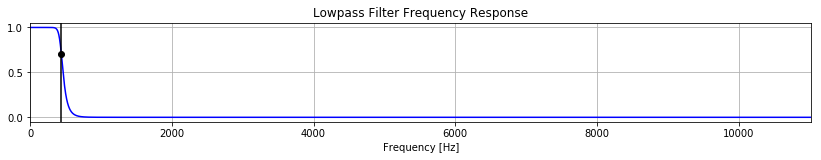

In [312]:
# Filter requirements.
order = 10
fs = Fs   # sample rate, Hz
cutoff = Fc  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = sp.freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()